- Welcome to Quantitative and High Frequency Trading Training Program


In [1]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)
get_signal_performance_result

<function helper.get_signal_performance_result(all_period_signal, signal_dire, period, product_list, train_sample, test_sample)>

- number of cores, set this number according to your computer

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [3]:
product_list = ["btc.usd.td", "eth.usd.td", "btc.usdt", "eth.usdt"]

In [4]:
import dask
from dask import compute, delayed

- sample period

In [6]:
period = 4096

- choose an example day

- Now we start our new topics:
- cross-period signal
- cross-symbol signal
- arbitrage

- First, we look at cross-period signal

In [11]:
SAVE_PATH = "e:/intern"
period_list =  np.power(2, range(10,13))

- we can first generate good index of data
- because loading data each time is too time consuming

In [8]:
def get_comb_signal(date, signal_func, product, period_list, HEAD_PATH, weight):
    comb_signal = []
    good = load(HEAD_PATH+"/good pkl/"+product+"/"+date)
    n_period = len(period_list)
    total = (sum(1/period_list))
    for i in range(n_period):
        signal_name = signal_func+"."+str(period_list[i])
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+date)
        #S = S/np.std(S[good])/n_period
        S = S*weight[i]
        if len(comb_signal)==0:
            comb_signal=S
        else:
            comb_signal += S
    save(comb_signal, HEAD_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb/"+date)
    

In [20]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
len(all_signal_list)
all_comb_list = [signal+".comb" for signal in all_signal_list]
all_period_signal = [signal+".4096" for signal in all_signal_list]
weight = (1/np.sqrt(period_list))/(sum(1/np.sqrt(period_list)))

In [18]:
for product in product_list:
    for signal_func in all_signal_list:
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb", exist_ok=True)
    

In [21]:
%%time
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)[1:-1]
    for signal_func in all_signal_list:
        print(product,signal_func)
        parLapply(CORE_NUM, all_dates, get_comb_signal,signal_func=signal_func,  
                  product=product, period_list=period_list,HEAD_PATH=SAVE_PATH, weight=weight)
## Wall time: 2h 21min 11s

eth.usd.td nr
eth.usd.td dbook
eth.usd.td range.pos
eth.usd.td price.osci
eth.usd.td ma.dif.10
eth.usd.td kdj.k
eth.usd.td kdj.j
eth.usd.td nr.range
eth.usd.td dbook.range
eth.usd.td range.pos.range
eth.usd.td price.osci.range
eth.usd.td ma.dif.10.range
eth.usd.td kdj.k.range
eth.usd.td kdj.j.range
eth.usd.td nr.std
eth.usd.td dbook.std
eth.usd.td range.pos.std
eth.usd.td price.osci.std
eth.usd.td ma.dif.10.std
eth.usd.td kdj.k.std
eth.usd.td kdj.j.std
eth.usd.td nr.trend.index
eth.usd.td dbook.trend.index
eth.usd.td range.pos.trend.index
eth.usd.td price.osci.trend.index
eth.usd.td ma.dif.10.trend.index
eth.usd.td kdj.k.trend.index
eth.usd.td kdj.j.trend.index
btc.usdt nr
btc.usdt dbook
btc.usdt range.pos
btc.usdt price.osci
btc.usdt ma.dif.10
btc.usdt kdj.k
btc.usdt kdj.j
btc.usdt nr.range
btc.usdt dbook.range
btc.usdt range.pos.range
btc.usdt price.osci.range
btc.usdt ma.dif.10.range
btc.usdt kdj.k.range
btc.usdt kdj.j.range
btc.usdt nr.std
btc.usdt dbook.std
btc.usdt range.pos.std


In [27]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file) ## good singal
        signal = S[good]
        moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

In [28]:
%%time
SAVE_PATH = "e:/intern"
for product in product_list:
    print(product)
    all_dates = os.listdir(DATA_PATH + product)[1:-1]
    parLapply(CORE_NUM, all_comb_list, par_get_all_signal, file_list=all_dates, product=product, period=4096, HEAD_PATH=HEAD_PATH,
             SAVE_PATH=SAVE_PATH);

# btc.usd.td
# eth.usd.td
# btc.usdt
# eth.usdt
# Wall time: 31min 41s


btc.usd.td
eth.usd.td
btc.usdt
eth.usdt
Wall time: 31min 41s


In [29]:
## this is to evalute the performance of a signal on a product
def evaluate_signal(signal, all_dates, product, min_pnl, min_num, 
                    CORE_NUM, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern", period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0, save_path="signal result",reverse=0):
    signal_name = signal+"."+str(period) ## signal name, with period
    all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+signal_name+".pkl") ## get the distribution of the signal
    tranct = product_info[product]["tranct"] ## transaction cost of the product
    tranct_ratio = product_info[product]["tranct.ratio"] ## True: based on notional; False: fixed tranct
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001))) ## open threshold
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])): ## close threshold
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])])) ## threshold matrix
    if reverse>=0: ## trending signal
        print("reverse=1")
        trend_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=1, tranct=tranct, 
                                   max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH)
    if reverse<=0: ## reversal signal
        print("reverse=-1")
        reverse_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=-1, tranct=tranct, 
                        max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH)
    if reverse==0: ## both trending and reversal
        stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".pkl")
    elif reverse==1: ## just trend
        save(trend_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".trend.pkl")
    elif reverse==-1: ## just reversal
        save(reverse_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".reverse.pkl")

In [33]:
%%time
SIGNAL_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    all_dates = np.array(os.listdir(DATA_PATH + product)[1:-1])
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, 2/spread, 20, CORE_NUM, HEAD_PATH, SIGNAL_PATH,
                period="comb", split_str="2020", tranct=tranct, 
                max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20/spread, save_path="signal result atr")

#Wall time: 9h 30min 53s


btc.usd.td nr
reverse=1
reverse=-1
btc.usd.td dbook
reverse=1
reverse=-1
btc.usd.td range.pos
reverse=1
reverse=-1
btc.usd.td price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td ma.dif.10
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td kdj.k
reverse=1
reverse=-1
btc.usd.td kdj.j
reverse=1
reverse=-1
btc.usd.td nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td dbook.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td range.pos.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td price.osci.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td ma.dif.10.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td kdj.j.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td nr.std


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td dbook.std


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td price.osci.std


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td ma.dif.10.std


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usd.td dbook.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td range.pos.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td price.osci.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td ma.dif.10.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td kdj.k.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usd.td kdj.j.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
eth.usd.td nr
reverse=1
reverse=-1
eth.usd.td dbook
reverse=1
reverse=-1
eth.usd.td range.pos
reverse=1
reverse=-1
eth.usd.td price.osci
reverse=1
reverse=-1
eth.usd.td ma.dif.10
reverse=1
reverse=-1
eth.usd.td kdj.k
reverse=1
reverse=-1
eth.usd.td kdj.j
reverse=1
reverse=-1
eth.usd.td nr.range
reverse=1
reverse=-1
eth.usd.td dbook.range
reverse=1
reverse=-1
eth.usd.td range.pos.range
reverse=1
reverse=-1
eth.usd.td price.osci.range
reverse=1
reverse=-1
eth.usd.td ma.dif.10.range
reverse=1
reverse=-1
eth.usd.td kdj.k.range
reverse=1
reverse=-1
eth.usd.td kdj.j.range
reverse=1
reverse=-1
eth.usd.td nr.std
reverse=1
reverse=-1
eth.usd.td dbook.std
reverse=1
reverse=-1
eth.usd.td range.pos.std
reverse=1
reverse=-1
eth.usd.td price.osci.std
reverse=1
reverse=-1
eth.usd.td ma.dif.10.std
reverse=1
reverse=-1
eth.usd.td kdj.k.std
reverse=1
reverse=-1
eth.usd.td kdj.j.std
reverse=1
reverse=-1
eth.usd.td nr.trend.index
reverse=1
reverse=-1
eth.usd.td dbook.trend.index
rever

d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt ma.dif.10
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.k
reverse=1
reverse=-1
btc.usdt kdj.j
reverse=1
reverse=-1
btc.usdt nr.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
btc.usdt dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
btc.usdt kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt nr
reverse=1
reverse=-1
eth.usdt dbook
reverse=1
reverse=-1
eth.usdt range.pos
reverse=1
reverse=-1
eth.usdt price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt ma.dif.10
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.k
reverse=1
reverse=-1
eth.usdt kdj.j
reverse=1
reverse=-1
eth.usdt nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
eth.usdt kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
Wall time: 9h 30min 53s


- now we compare the result of comb signal and previous signal

In [35]:
## get the signal performance
## including trend and reverse signals
def get_signal_performance_result(all_period_signal, signal_dire, period, product_list):
    trend_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_period_signal), ("reverse",1),
                               ("num", 0), ("trainSharpe", 0), ("testSharpe", 0)]))
    reverse_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_period_signal), ("reverse",-1),
                               ("num", 0), ("trainSharpe", 0), ("testSharpe", 0)]))
    n_signal = len(all_period_signal) ## number of all signals
    trend_train_sharpe = np.zeros(len(product_list))
    trend_test_sharpe = np.zeros(len(product_list))
    reverse_train_sharpe = np.zeros(len(product_list))
    reverse_test_sharpe = np.zeros(len(product_list))
    for k in range(n_signal):
        signal_name = all_period_signal[k]
        i = 0
        for product in product_list:
            all_dates = np.array(os.listdir(DATA_PATH + product)[1:-1])
            train_sample = all_dates<"2020" 
            test_sample = all_dates>"2020"
            stat_result = load(HEAD_PATH+"/" + signal_dire +"/"+product+"."+signal_name+".pkl") ## statistics of signal over a product
            trend_signal_stat = stat_result['trend.signal.stat'] ## trending statistics
            spread = product_info[product]["spread"]            
            if product=="btc.usd.td" or product=="eth.usd.td":
                avg_pnl = 10
            else:
                avg_pnl = 200

            if tuple(trend_signal_stat.keys())[0]=='train.stat':
                train_stat = trend_signal_stat["train.stat"]
                test_stat = trend_signal_stat["test.stat"]
                #good_strat = trend_signal_stat["good.strat"]
                good_strat = (train_stat["final.result"]["avg.pnl"]>avg_pnl*spread) & (train_stat["final.result"]["num"]>10) ## filter criterion
                if sum(good_strat)>2:
                    train_stat = trend_signal_stat["train.stat"]
                    test_stat = trend_signal_stat["test.stat"]
                    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) ## get the daily return
                    #train_std = np.std(train_pnl)
                    #train_pnl = train_pnl/train_std
                    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
                    trend_train_sharpe[i] = sharpe(train_pnl)
                    trend_test_sharpe[i] = sharpe(test_pnl)
                    #print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
                    i = i+1
            if i>0: ## if there are any good products
                trend_signal_result.loc[k, ("signal", "num", "trainSharpe", "testSharpe")] = (signal_name, i,  np.mean(trend_train_sharpe[:i]),np.mean(trend_test_sharpe[:i]))
        i = 0
        for product in product_list:
            stat_result = load(HEAD_PATH+"/"+signal_dire+"/"+product+"."+signal_name+".pkl")
            reverse_signal_stat = stat_result['reverse.signal.stat']
            spread = product_info[product]["spread"]
            if tuple(reverse_signal_stat.keys())[0]=='train.stat':
                #good_strat = reverse_signal_stat["good.strat"]
                train_stat = reverse_signal_stat["train.stat"]
                train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) ## get the daily return
                test_stat = reverse_signal_stat["test.stat"]
                good_strat = (train_stat["final.result"]["avg.pnl"]>avg_pnl*spread) & (train_stat["final.result"]["num"]>10)
                test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
                if sum(good_strat)>2:
                    #train_std = np.std(train_pnl)
                    #train_pnl = train_pnl/train_std
                    reverse_train_sharpe[i] = sharpe(train_pnl)
                    reverse_test_sharpe[i] = sharpe(test_pnl)
                    i = i+1
            if i>0:
                
                reverse_signal_result.loc[k, ("signal","num", "trainSharpe", "testSharpe")] = (signal_name, i, np.mean(reverse_train_sharpe[:i]),np.mean(reverse_test_sharpe[:i]))
    return OrderedDict([("trend.signal.stat", trend_signal_result), 
                        ("reverse.signal.stat", reverse_signal_result)])


In [36]:
def get_single_signal_stat(result_atr, min_num=0, min_sharpe=0.5):
    good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>min_sharpe) & (result_atr["trend.signal.stat"]["testSharpe"]>min_sharpe)
    good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>min_sharpe) & (result_atr["reverse.signal.stat"]["testSharpe"]>min_sharpe)
    print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
    train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                      result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
    test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                      result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
    print("train sharpe: ", train_sharpe)
    print("test sharpe: ", test_sharpe)
    print(all_signal_list[good_trend])
    print(all_signal_list[good_reverse])


In [38]:
result_atr = get_signal_performance_result(all_period_signal, "signal result atr", 4096, product_list)
result_comb= get_signal_performance_result(all_comb_list, "signal result atr", "comb", product_list)

In [40]:
get_single_signal_stat(result_atr, min_num=0, min_sharpe=0.5)
get_single_signal_stat(result_comb, min_num=0, min_sharpe=0.5)

# with atr good signals: 5
# train sharpe:  0.78458852587399
# test sharpe:  1.7879568608673875
# ['nr' 'range.pos' 'nr.range' 'range.pos.range' 'nr.std']
# []
# with atr good signals: 2
# train sharpe:  0.6724121007921882
# test sharpe:  2.2040313968101986
# ['range.pos.range' 'nr.std']
# []




with atr good signals: 5
train sharpe:  0.78458852587399
test sharpe:  1.7879568608673875
['nr' 'range.pos' 'nr.range' 'range.pos.range' 'nr.std']
[]
with atr good signals: 2
train sharpe:  0.6724121007921882
test sharpe:  2.2040313968101986
['range.pos.range' 'nr.std']
[]


In [41]:
get_single_signal_stat(result_atr, min_num=1, min_sharpe=0.5)
get_single_signal_stat(result_comb, min_num=1, min_sharpe=0.5)

# with atr good signals: 1
# train sharpe:  1.3684328000205555
# test sharpe:  0.8091649445937805
# ['range.pos']
# []
# with atr good signals: 0
# train sharpe:  nan
# test sharpe:  nan
# []
# []

with atr good signals: 1
train sharpe:  1.3684328000205555
test sharpe:  0.8091649445937805
['range.pos']
[]
with atr good signals: 0
train sharpe:  nan
test sharpe:  nan
[]
[]


d:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- the signal with combination is worse than the signal with just 4096 period

- we can see that with atr fitler the result is a little bit worse 
- also we can see that signal of 4096 ticks perform better than combination of signals
- maybe we can use strategies of each period (1024/2048/4096) and then combine them together
- rather than combine them first and then construct strategies
- now we go to cross-symbol signals and arbitrage

In [7]:
product_x = "btc.usd.td"
product_y = "eth.usd.td"
date = "2020-04-10.pkl"
SAVE_PATH = "e:/intern"
data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+date)
data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+date)

In [8]:
os.makedirs(HEAD_PATH+"/comb time", exist_ok=True)
os.makedirs(HEAD_PATH+"/comb time/"+product_x+"_"+product_y, exist_ok=True)

In [24]:
all_dates_x = os.listdir(DATA_PATH + product_x)[1:-1]
all_dates_y = os.listdir(DATA_PATH + product_y)[1:-1]
all_dates = set(all_dates_x) & set(all_dates_y)

In [28]:
from collections import Counter
def get_crypto_comb_pos(date, product_x, product_y, HEAD_PATH):
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+date)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+date)
    data_x = data_x[data_x["good"]]
    data_y = data_y[data_y["good"]]
    data_x["contract"] = product_x
    data_y["contract"] = product_y
    comb_time = np.append(data_x["time"], data_y["time"])
    sort_index = np.argsort(comb_time)
    comb_time = comb_time[sort_index]    
    data = data_x.append(data_y)
    data = data.iloc[sort_index,:]
    time_x = data["contract"]==product_x
    time_y = data["contract"]==product_y
    save([sort_index, time_x, time_y], HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+date)

In [29]:
%%time
result = parLapply(CORE_NUM, all_dates, get_crypto_comb_pos, product_x=product_x, product_y=product_y, HEAD_PATH=HEAD_PATH)

#Wall time: 3min 4s


Wall time: 3min 4s


- let's go to arbitrage

In [45]:
def par_get_crypto_arb_all_signal(signal_name, file_list, product_x, product_y, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        good_x = load(SAVE_PATH + "/good pkl/"+product_x+"/"+file)
        good_y = load(SAVE_PATH + "/good pkl/"+product_y+"/"+file)
        S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)[good_x]
        S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)[good_y]
        [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
        extend_x = np.append(S_x,S_y)
        extend_x[time_y] = np.nan
        extend_y = np.append(S_x,S_y)
        extend_y[time_x] = np.nan
        extend_x[0] = S_x[0]
        extend_y[0] = S_y[0]
        extend_x = pd.DataFrame(extend_x)
        extend_y = pd.DataFrame(extend_y)
        extend_x.ffill(inplace=True)
        extend_y.ffill(inplace=True)
        signal = np.array((extend_x-extend_y)[0])
        chosen = (np.arange(len(signal))+1) % period==0
        moving_average(signal,period)
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, HEAD_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [137]:
%%time
result = par_get_crypto_arb_all_signal("kdj.j.4096",  file_list=all_dates, product_x=product_x, 
                   product_y = product_y, period=4096, HEAD_PATH=HEAD_PATH, SAVE_PATH = SAVE_PATH)

# Wall time:  38.6 s

Wall time: 34.4 s


In [64]:
def get_combine_data(file, product_x, product_y, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+file)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    data_x = data_x[data_x["good"]].reset_index(drop=True)
    data_y = data_y[data_y["good"]].reset_index(drop=True)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    extend_data_x = data_x.append(data_y)
    extend_data_x = extend_data_x.reset_index(drop=True)
    extend_data_x = extend_data_x.iloc[sort_index]
    extend_data_x = extend_data_x.reset_index(drop=True)
    extend_data_x.loc[list(time_y), ("bid", "ask", "next.bid", "next.ask")] = np.nan
    extend_data_x.loc[0] = data_x.loc[0]
    extend_data_x.ffill(inplace=True)
    extend_data_y = data_x.append(data_y)
    extend_data_y = extend_data_y.reset_index(drop=True)
    extend_data_y = extend_data_y.iloc[sort_index]
    extend_data_y = extend_data_y.reset_index(drop=True)
    extend_data_y.loc[list(time_x), ("bid", "ask", "next.bid", "next.ask")] = np.nan
    extend_data_y.loc[0] = data_y.iloc[0]
    extend_data_y.ffill(inplace=True)
    data = extend_data_x.loc[:,("time","good", "bid", "ask", "next.bid", "next.ask")]
    data["y.bid"] = extend_data_y["bid"].values
    data["y.ask"] = extend_data_y["ask"].values
    data["y.next.bid"] = extend_data_y["next.bid"].values
    data["y.next.ask"] = extend_data_y["next.ask"].values
    save(data, HEAD_PATH+"/pkl tick/"+product_x+"_"+product_y+"/"+file)

In [65]:
os.makedirs(HEAD_PATH+"/pkl tick/"+product_x+"_"+product_y, exist_ok=True)

In [66]:
%%time
result = parLapply(CORE_NUM, all_dates, get_combine_data, product_x=product_x, product_y = product_y, 
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH);

# Wall time: 3min 10s


Wall time: 3min 10s


In [102]:
from collections import OrderedDict
def get_crypto_cross_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, 
                                tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern",
                   atr_filter=0, rebate=0):
    ## load data
    data = load(HEAD_PATH+"/pkl tick/"+product_x+"_"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    extend_x = np.append(S_x, S_y)
    extend_x = extend_x[sort_index]
    extend_x[time_y] = np.nan
    extend_x[0] = S_x[0]
    extend_x = pd.DataFrame(extend_x)
    extend_x.ffill(inplace=True)
    atr_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+"atr.4096"+"/"+file)
    atr_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+"atr.4096"+"/"+file)
    extend_atr_x = np.append(atr_x, atr_y)
    extend_atr_x = extend_atr_x[sort_index]
    extend_atr_x[time_y] = np.nan
    extend_atr_x[0] = atr_x[0]
    extend_atr_x = pd.DataFrame(extend_atr_x)
    extend_atr_x.ffill(inplace=True)
    atr = extend_atr_x
    S = extend_x
    pred = S*reverse
    pred = pred[data["good"]].reset_index(drop=True)[0]
    data = data[data["good"]].reset_index(drop=True)    
    data_x = np.nan
    data_y = np.nan
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread = data["y.ask"]-data["y.bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["y.next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["y.next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["y.next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["y.next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["y.next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["y.next.ask"][change_buy]+tranct
            change_base[change_sell] = data["y.next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base*notional_change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [252]:
signal_name = "kdj.j.4096" 

In [142]:
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [143]:
from collections import OrderedDict
def get_crypto_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", min_pnl=2, min_num=20, atr_filter=0):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_crypto_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio,HEAD_PATH=HEAD_PATH,
                                  SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_crypto_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

In [144]:
def evaluate_crypto_cross_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, SAVE_PATH,
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0, save_path="signal result"):
    signal_name = signal+"."+str(period)
    all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")
    tranct = product_info[product_y]["tranct"]
    tranct_ratio = product_info[product_y]["tranct.ratio"]
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_crypto_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str=split_str, reverse=1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    print("reverse=-1")
    reverse_signal_stat = get_crypto_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str=split_str, reverse=-1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,  min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [91]:
all_dates = np.sort(np.array(list(all_dates)))

In [145]:
%%time
result = evaluate_crypto_cross_signal("kdj.j", all_dates, product_x,product_y, 2, 20, HEAD_PATH, SAVE_PATH,
                CORE_NUM, period=4096, split_str="2020", tranct=7.5e-4, 
                max_spread=0.06,tranct_ratio=True, atr_filter=20, save_path="signal result atr")

# reverse=1
# reverse=-1
# Wall time: 42min 17s


reverse=1
reverse=-1
Wall time: 42min 17s


In [146]:
result = load(HEAD_PATH+"/signal result atr/"+product_x+"_"+product_y+".kdj.j.4096.pkl")

1.347059382200848 1.7776295079802713


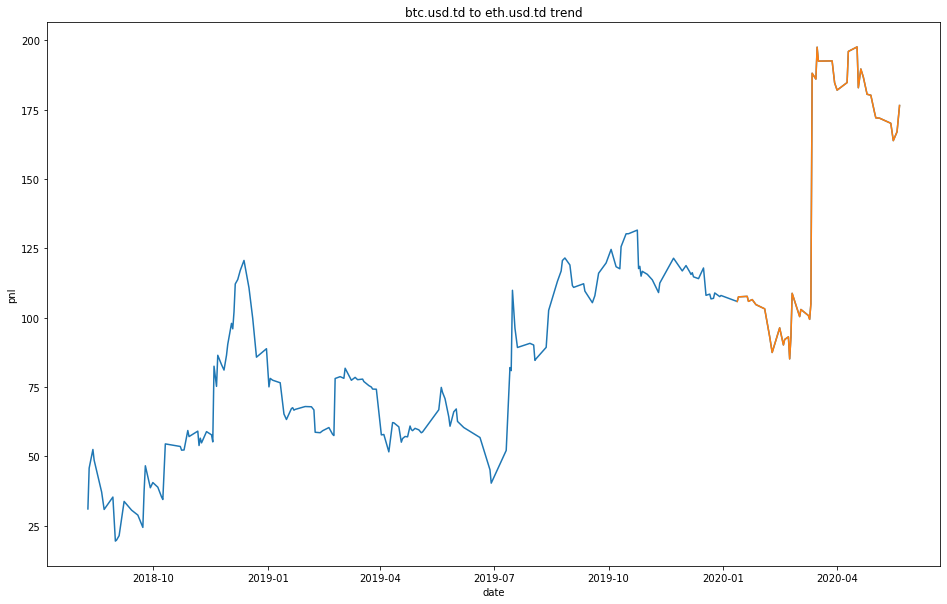

In [147]:
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
train_stat =result["trend.signal.stat"]["train.stat"]
train_sample = all_dates<"2020"
test_sample = all_dates>"2020"
spread = product_info[product_y]["spread"]
good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread) & (train_stat["final.result"]["num"]>20)
train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
test_stat =result["trend.signal.stat"]["test.stat"]
test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" to "+product_y+" trend");
plt.plot(format_dates, pnl.cumsum());
plt.plot(format_dates[test_sample], pnl.cumsum()[test_sample])
print(sharpe(train_pnl), sharpe(test_pnl))
## 1.347059382200848 1.7776295079802713

- we can see that strategies in training set can still perform well in test set

In [226]:
## backtest arbitrage signal strategy
## each time buy a product and sell another
## long the pair means long product x and short product y with the same notional value
from collections import OrderedDict
def get_crypto_arb_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread_x=1.1,
                       max_spread_y=1.1,tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", rebate=0, signal_thre=11e-4):
    ## load data
    data = load(HEAD_PATH+"/pkl tick/"+product_x+"_"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    ## load signals
    good_x = load(SAVE_PATH + "/good pkl/"+product_x+"/"+file)
    good_y = load(SAVE_PATH + "/good pkl/"+product_y+"/"+file)
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)[good_x]
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)[good_y]
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    extend_x = np.append(S_x,S_y)
    extend_x[time_y] = np.nan
    extend_y = np.append(S_x,S_y)
    extend_y[time_x] = np.nan
    extend_x[0] = S_x[0]
    extend_y[0] = S_y[0]
    extend_x = pd.DataFrame(extend_x)
    extend_y = pd.DataFrame(extend_y)
    extend_x.ffill(inplace=True)
    extend_y.ffill(inplace=True)
    S = np.array((extend_x-extend_y)[0]) ## difference of two signals
    pred = S*reverse
    #pred = pred[data["good"]].reset_index(drop=True)[0]
    data = data[data["good"]].reset_index(drop=True)    
    data_x = np.nan
    data_y = np.nan
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread_x = data["ask"]-data["bid"]
    cur_spread_y = data["y.ask"]-data["y.bid"]
    n_bar = len(data)
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        ## long means buy product x at next.ask and sell product y at next bid
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (data["y.next.ask"]>0) & (cur_spread_x<max_spread_x) &
                    (cur_spread_y<max_spread_y)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos_x = pd.Series(data=0, index=data.index)
        notional_position_pos_y = pd.Series(data=0, index=data.index)
        notional_position_pos_x[position_pos==1] = 1
        notional_position_pos_x[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_y[position_pos==1] = 1
        notional_position_pos_y[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_x[(notional_position_pos_x==1)] = 1/data["next.ask"][(notional_position_pos_x==1)]
        notional_position_pos_y[(notional_position_pos_y==1)] = -1/data["y.next.bid"][(notional_position_pos_y==1)]
        notional_position_pos_x.ffill(inplace=True)
        notional_position_pos_y.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        ## short means sell product x at next.bid and buy product y at next ask
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg_x = pd.Series(data=0, index=data.index)
        notional_position_neg_y = pd.Series(data=0, index=data.index)
        notional_position_neg_x[position_neg==-1] = -1
        notional_position_neg_x[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_y[position_neg==-1] = -1
        notional_position_neg_y[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_x[(notional_position_neg_x==-1)] = -1/data["next.bid"][(notional_position_neg_x==-1)]
        notional_position_neg_y[(notional_position_neg_y==-1)] = 1/data["y.next.ask"][(notional_position_neg_y==-1)]
        notional_position_neg_x.ffill(inplace=True)
        notional_position_neg_y.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position_x = notional_position_pos_x+notional_position_neg_x
        notional_position_y = notional_position_pos_y+notional_position_neg_y
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position_x.iloc[0] = 0
        notional_position_y.iloc[0] = 0
        notional_position_x.iloc[-10:] = 0
        notional_position_y.iloc[-10:] = 0
        notional_change_pos_x = notional_position_x-notional_position_x.shift(1)
        notional_change_pos_y = notional_position_y-notional_position_y.shift(1)
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos_x.iloc[0] = 0
        notional_change_pos_y.iloc[0] = 0
        change_base_x = pd.Series(data=0, index=data.index)
        change_base_y = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base_x[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base_x[change_sell] = data["next.bid"][change_sell]*(1-tranct)
            change_base_y[change_buy] = data["y.next.bid"][change_buy]*(1-tranct)
            change_base_y[change_sell] = data["y.next.ask"][change_sell]*(1+tranct)
        else:
            change_base_x[change_buy] = data["next.ask"][change_buy]+tranct
            change_base_x[change_sell] = data["next.bid"][change_sell]-tranct
            change_base_y[change_buy] = data["y.next.bid"][change_buy]-tranct
            change_base_y[change_sell] = data["y.next.ask"][change_sell]+tranct
        final_pnl = -sum(change_base_x*change_pos)-sum(change_base_y*change_pos)
        ret = -sum(change_base_x*notional_change_pos_x)-sum(change_base_y*notional_change_pos_y)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [254]:
signal_name = "kdj.j.4096" 
product_x = "btc.usd.td"
product_y = "eth.usd.td"
thre_list = []
#open_list = np.quantile(abs(all_signal), np.arange(0.99991,0.99999,0.00001))
open_list = np.arange(0.6,1,0.02)
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat

,open,close
0,0.60,-0.120
1,0.60,-0.240
2,0.60,-0.360
3,0.60,-0.480
4,0.60,-0.600
...,...,...
95,0.98,-0.196
96,0.98,-0.392
97,0.98,-0.588
98,0.98,-0.784


In [243]:
%%time
train_result = parLapply(CORE_NUM, all_dates[train_sample], get_crypto_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name="kdj.j.4096",
                   thre_mat=thre_mat, reverse=-1, tranct=7.5e-4, max_spread_x=0.6,
                        max_spread_y=0.06,tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern")
test_result = parLapply(CORE_NUM, all_dates[test_sample], get_crypto_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name="kdj.j.4096",
                  thre_mat=thre_mat, reverse=-1, tranct=7.5e-4, max_spread_x=0.6,
                       max_spread_y=0.06,tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern")
# Wall time: 2min 1s

Wall time: 7min 43s


In [244]:
train_stat = get_hft_summary(train_result, thre_mat,sum(train_sample))
good_strat = (train_stat["final.result"]["avg.pnl"]>4) & (train_stat["final.result"]["num"]>10)
sum(good_strat)

0

In [246]:
train_stat["final.result"]

,open,close,num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret
0,0.60,-0.120,85,-38.744156,-3293.253263,-2.734065,3191.917913,3191.917913,-0.002589,-0.220039,-1.602190,0.251511,0.265183,-1.031747,-0.829766
1,0.60,-0.240,85,-38.738866,-3292.803600,-2.733607,3191.917913,3191.917913,-0.002613,-0.222096,-1.607313,0.253567,0.267239,-1.031607,-0.831076
2,0.60,-0.360,85,-39.218573,-3333.578700,-2.766068,3232.693013,3232.693013,-0.002444,-0.207722,-1.512760,0.239194,0.252865,-1.031208,-0.821473
3,0.60,-0.480,85,-33.819003,-2874.615288,-2.320829,2854.075150,2878.290463,-0.002603,-0.221234,-1.609342,0.252705,0.266975,-0.998723,-0.828667
4,0.60,-0.600,85,-33.819003,-2874.615288,-2.320829,2854.075150,2878.290463,-0.002603,-0.221234,-1.609342,0.252705,0.266975,-0.998723,-0.828667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.98,-0.196,23,-16.133798,-371.077350,-0.813250,765.961363,765.961363,-0.006537,-0.150358,-2.864587,0.150358,0.150358,-0.484460,-1.000000
96,0.98,-0.392,23,-16.133798,-371.077350,-0.813250,765.961363,765.961363,-0.006537,-0.150358,-2.864587,0.150358,0.150358,-0.484460,-1.000000
97,0.98,-0.588,23,-11.715956,-269.466988,-0.582338,744.696550,744.696550,-0.006748,-0.155202,-2.976592,0.155202,0.155202,-0.361848,-1.000000
98,0.98,-0.784,23,-11.715956,-269.466988,-0.582338,744.696550,744.696550,-0.006748,-0.155202,-2.976592,0.155202,0.155202,-0.361848,-1.000000


In [248]:
test_stat = get_hft_summary(test_result, thre_mat,sum(test_sample))
good_strat = (test_stat["final.result"]["avg.pnl"]>4) & (test_stat["final.result"]["num"]>10)
sum(good_strat)


0

In [251]:
train_stat["final.result"]["avg.ret"]>0

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: avg.ret, Length: 100, dtype: bool

In [250]:
test_stat["final.result"]["avg.ret"]>0

0     False
1     False
2     False
3     False
4     False
      ...  
95     True
96     True
97     True
98     True
99     True
Name: avg.ret, Length: 100, dtype: bool

- we can see that there are no good strategies for a-m arbitrage
- the reason may be that oil contracts have too low volatility and intraday trading cannot cover transaction cost
